In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
current_dir = "/kaggle/input/isic-2024-challenge"

# List all files in the current directory (excluding subdirectories)
files_in_dir = [f for f in os.listdir(current_dir)]
for file in files_in_dir:
    print(file)

    
# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

sample_submission.csv
train-metadata.csv
test-metadata.csv
test-image.hdf5
train-image
train-image.hdf5


## Libraries and dependencies

In [2]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import os 
import h5py
import cv2
from tqdm.notebook import tqdm
from concurrent.futures import ThreadPoolExecutor,ProcessPoolExecutor, as_completed
from google.colab.patches import cv2_imshow
from IPython.display import display, Javascript
import plotly.express as px
from sklearn.model_selection import train_test_split,cross_val_score
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer,SimpleImputer,KNNImputer
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder, FunctionTransformer
from sklearn.feature_extraction import FeatureHasher
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.neighbors import NearestNeighbors
from sklearn.metrics import accuracy_score, mean_squared_error,get_scorer_names
from sklearn.preprocessing import LabelEncoder,MinMaxScaler,StandardScaler
from sklearn.linear_model import LogisticRegression, LinearRegression,SGDClassifier
from sklearn.utils import resample
from sklearn.utils import shuffle
from sklearn.utils.class_weight import compute_class_weight
from imblearn.combine import *
from imblearn.under_sampling import *
from imblearn.over_sampling import *
from imblearn.pipeline import Pipeline
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import random
import warnings
warnings.filterwarnings("ignore")

In [3]:
# Deep learning keras libraries
import keras
print(keras.__version__)
from keras import backend as K
from keras.losses import Loss
import tensorflow as tf
from keras.layers import Input, Conv2D, MaxPooling2D,GlobalAveragePooling2D, Flatten, Dense, Dropout, BatchNormalization, Concatenate
from keras import ops
import keras_hub
from keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
import math
from keras import ops
from keras import layers
from keras.saving import register_keras_serializable

3.5.0


In [4]:
# CONFIG VARIABLES AND PARAMETERS
IMAGE_HEIGHT = 72
IMAGE_WIDTH = 72
# BATCH_SIZE = 64
# DATA
BUFFER_SIZE = 512
BATCH_SIZE = 256

# AUGMENTATION
IMAGE_SIZE = 72
PATCH_SIZE = 6
NUM_PATCHES = (IMAGE_SIZE // PATCH_SIZE) ** 2

# ARCHITECTURE
LAYER_NORM_EPS = 1e-6
TRANSFORMER_LAYERS = 8
PROJECTION_DIM = 64
NUM_HEADS = 4
TRANSFORMER_UNITS = [
    PROJECTION_DIM * 2,
    PROJECTION_DIM,
]
MLP_HEAD_UNITS = [1024,512]
NUM_CLASSES = 1
keras.utils.set_random_seed(48)

## Data loading


In [5]:
current_dir = "/kaggle/input/isic-2024-challenge"
sample_submission = pd.read_csv(os.path.join(current_dir,'sample_submission.csv'))
sample_submission.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3 entries, 0 to 2
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   isic_id  3 non-null      object 
 1   target   3 non-null      float64
dtypes: float64(1), object(1)
memory usage: 176.0+ bytes


In [6]:
sample_submission.head()

,isic_id,target
0,ISIC_0015657,0.3
1,ISIC_0015729,0.3
2,ISIC_0015740,0.3


In [7]:
train_metadata = pd.read_csv(os.path.join(current_dir,'train-metadata.csv'),low_memory=False)
train_metadata.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 401059 entries, 0 to 401058
Data columns (total 55 columns):
 #   Column                        Non-Null Count   Dtype  
---  ------                        --------------   -----  
 0   isic_id                       401059 non-null  object 
 1   target                        401059 non-null  int64  
 2   patient_id                    401059 non-null  object 
 3   age_approx                    398261 non-null  float64
 4   sex                           389542 non-null  object 
 5   anatom_site_general           395303 non-null  object 
 6   clin_size_long_diam_mm        401059 non-null  float64
 7   image_type                    401059 non-null  object 
 8   tbp_tile_type                 401059 non-null  object 
 9   tbp_lv_A                      401059 non-null  float64
 10  tbp_lv_Aext                   401059 non-null  float64
 11  tbp_lv_B                      401059 non-null  float64
 12  tbp_lv_Bext                   401059 non-nul

In [8]:
train_metadata.head()

,isic_id,target,patient_id,age_approx,sex,anatom_site_general,clin_size_long_diam_mm,image_type,tbp_tile_type,tbp_lv_A,...,lesion_id,iddx_full,iddx_1,iddx_2,iddx_3,iddx_4,iddx_5,mel_mitotic_index,mel_thick_mm,tbp_lv_dnn_lesion_confidence
0,ISIC_0015670,0,IP_1235828,60.0,male,lower extremity,3.04,TBP tile: close-up,3D: white,20.244422,...,NaN,Benign,Benign,NaN,NaN,NaN,NaN,NaN,NaN,97.517282
1,ISIC_0015845,0,IP_8170065,60.0,male,head/neck,1.10,TBP tile: close-up,3D: white,31.712570,...,IL_6727506,Benign,Benign,NaN,NaN,NaN,NaN,NaN,NaN,3.141455
2,ISIC_0015864,0,IP_6724798,60.0,male,posterior torso,3.40,TBP tile: close-up,3D: XP,22.575830,...,NaN,Benign,Benign,NaN,NaN,NaN,NaN,NaN,NaN,99.804040
3,ISIC_0015902,0,IP_4111386,65.0,male,anterior torso,3.22,TBP tile: close-up,3D: XP,14.242329,...,NaN,Benign,Benign,NaN,NaN,NaN,NaN,NaN,NaN,99.989998
4,ISIC_0024200,0,IP_8313778,55.0,male,anterior torso,2.73,TBP tile: close-up,3D: white,24.725520,...,NaN,Benign,Benign,NaN,NaN,NaN,NaN,NaN,NaN,70.442510


In [9]:
test_metadata = pd.read_csv(os.path.join(current_dir,'test-metadata.csv'),low_memory=False)
test_metadata.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3 entries, 0 to 2
Data columns (total 44 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   isic_id                      3 non-null      object 
 1   patient_id                   3 non-null      object 
 2   age_approx                   3 non-null      float64
 3   sex                          3 non-null      object 
 4   anatom_site_general          3 non-null      object 
 5   clin_size_long_diam_mm       3 non-null      float64
 6   image_type                   3 non-null      object 
 7   tbp_tile_type                3 non-null      object 
 8   tbp_lv_A                     3 non-null      float64
 9   tbp_lv_Aext                  3 non-null      float64
 10  tbp_lv_B                     3 non-null      float64
 11  tbp_lv_Bext                  3 non-null      float64
 12  tbp_lv_C                     3 non-null      float64
 13  tbp_lv_Cext             

In [10]:
test_metadata.head()

,isic_id,patient_id,age_approx,sex,anatom_site_general,clin_size_long_diam_mm,image_type,tbp_tile_type,tbp_lv_A,tbp_lv_Aext,...,tbp_lv_radial_color_std_max,tbp_lv_stdL,tbp_lv_stdLExt,tbp_lv_symm_2axis,tbp_lv_symm_2axis_angle,tbp_lv_x,tbp_lv_y,tbp_lv_z,attribution,copyright_license
0,ISIC_0015657,IP_6074337,45.0,male,posterior torso,2.70,TBP tile: close-up,3D: XP,22.80433,20.007270,...,0.304827,1.281532,2.299935,0.479339,20,-155.06510,1511.222000,113.980100,Memorial Sloan Kettering Cancer Center,CC-BY
1,ISIC_0015729,IP_1664139,35.0,female,lower extremity,2.52,TBP tile: close-up,3D: XP,16.64867,9.657964,...,0.000000,1.271940,2.011223,0.426230,25,-112.36924,629.535889,-15.019287,"Frazer Institute, The University of Queensland...",CC-BY
2,ISIC_0015740,IP_7142616,65.0,male,posterior torso,3.16,TBP tile: close-up,3D: XP,24.25384,19.937380,...,0.230742,1.080308,2.705857,0.366071,110,-84.29282,1303.978000,-28.576050,FNQH Cairns,CC-BY


#### Load Image Byte String

In this competition, images are provided as byte strings. The following code snippet demonstrates how to load these images into memory. One might wonder why the provided jpeg images aren't being used in the /train-image folder for training. This is because testing images are not provided as JPEG images; instead, they are provided as byte strings. Why use byte strings? They occupy significantly less memory compared to np.array representations.


In [11]:
# image sample visualization
training_validation_hdf5 = h5py.File(f"{current_dir}/train-image.hdf5", 'r')
testing_hdf5 = h5py.File(f"{current_dir}/test-image.hdf5", 'r')

Image ISIC_1472148:
Shape:(117, 117, 3)


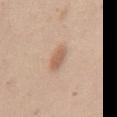

Image ISIC_2153690:
Shape:(131, 131, 3)


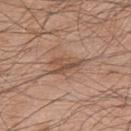

In [12]:
# sample randomly two images from the train dataset
img_sample = train_metadata['isic_id'].sample(n=2).to_list()

# load the image from byte arrays, 
byte_str = [training_validation_hdf5[isic_id][()] for isic_id in img_sample]

# convert byte str to numpy array
img_arr = [np.frombuffer(byte, np.uint8) for byte in byte_str]

# convert cv2 image
img_cv2 = [cv2.imdecode(nparr, cv2.IMREAD_COLOR) for nparr in img_arr] 
for ind,val in enumerate(img_cv2):
    print(f"Image {img_sample[ind]}:")
    print(f"Shape:{val.shape}")
    cv2_imshow(val)

Image ISIC_0015729:
Shape:(125, 125, 3)


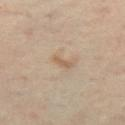

Image ISIC_0015657:
Shape:(141, 141, 3)


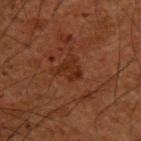

Image ISIC_0015740:
Shape:(119, 119, 3)


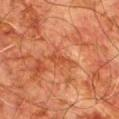

In [13]:
# sample randomly two images from the train dataset
img_sample = test_metadata['isic_id'].sample(n=3).to_list()

# load the image from byte arrays, 
byte_str = [testing_hdf5[isic_id][()] for isic_id in img_sample]

# convert byte str to numpy array
img_arr = [np.frombuffer(byte, np.uint8) for byte in byte_str]

# convert cv2 image
img_cv2 = [cv2.imdecode(nparr, cv2.IMREAD_COLOR) for nparr in img_arr] 
for ind,val in enumerate(img_cv2):
    print(f"Image {img_sample[ind]}:")
    print(f"Shape:{val.shape}")
    cv2_imshow(val)

## Preprocessing 

In [14]:
class DataPreprocessor:
    def __init__(self):
        self.preprocessor = None
        self.train_columns = None

    def fit_transform(self, df):
        """Preprocess training data and store transformations."""
        df = df.copy()
        df = self._drop_irrelevant_columns(df)
        df = self._drop_train_only_columns(df)
        categorical_cols, numerical_cols = self._identify_column_types(df)
        
        # Define preprocessing pipelines
        numerical_pipeline = Pipeline([
            ("imputer", KNNImputer()),
            ("scaler", StandardScaler())
        ])
        
        categorical_pipeline = Pipeline([
            ("onehot", OneHotEncoder(handle_unknown="ignore"))
        ])
        
        self.preprocessor = ColumnTransformer([
            ("num", numerical_pipeline, numerical_cols),
            ("cat", categorical_pipeline, categorical_cols)
        ])
        
        transformed_data = self.preprocessor.fit_transform(df)
        
        cat_feature_names = self.preprocessor.named_transformers_["cat"].named_steps["onehot"].get_feature_names_out(categorical_cols)
        all_columns = numerical_cols + list(cat_feature_names)
        
        df_processed = pd.DataFrame(transformed_data, columns=all_columns)
        df_processed["isic_id"] = df["isic_id"].values
        df_processed["target"] = df["target"].values
        
        self.train_columns = df_processed.columns  # Store train columns
        return df_processed

    def transform(self, df):
        """Preprocess test data using stored transformations from training."""
        df = df.copy()
        df = self._drop_irrelevant_columns(df)
        
        transformed_data = self.preprocessor.transform(df)
        cat_feature_names = self.preprocessor.named_transformers_["cat"].named_steps["onehot"].get_feature_names_out()
        all_columns = self.train_columns[:-2]  # Exclude 'isic_id' and 'target'
        
        df_processed = pd.DataFrame(transformed_data, columns=all_columns)
        df_processed["isic_id"] = df["isic_id"].values
        # df_processed["target"] = df["target"].values
        
        # Align test dataset with train columns
        df_processed = self._align_train_test_columns(df_processed)
        return df_processed

    def _drop_irrelevant_columns(self, df):
        """Remove unnecessary columns."""
        return df.drop(columns=['patient_id','image_type', 'tbp_tile_type', 'attribution', 'copyright_license'], errors="ignore")

    def _drop_train_only_columns(self,df):
        """Remove columns that are present only in the train set and not in the test set"""
        drop_train_only_columns = [
            'lesion_id', 'iddx_full', 'iddx_1', 'iddx_2', 'iddx_3', 'iddx_4', 'iddx_5',
            'mel_mitotic_index', 'mel_thick_mm', 'tbp_lv_dnn_lesion_confidence'
            ]
        return df.drop(columns=drop_train_only_columns,errors='ignore')
        

    def _identify_column_types(self, df):
        """Identify categorical and numerical columns, excluding 'isic_id' and 'target'."""
        categorical_cols = df.select_dtypes(include=['object']).columns.tolist()
        numerical_cols = df.select_dtypes(include=['int64', 'float64']).columns.tolist()
        categorical_cols = [col for col in categorical_cols if col != "isic_id"]
        numerical_cols = [col for col in numerical_cols if col != "target"]
        return categorical_cols, numerical_cols
    
    def _align_train_test_columns(self, df):
        """Ensure test data has the same columns as train data."""
        train_cols = list(self.train_columns)
        train_cols.remove('target')
        missing_cols = set(train_cols) - set(df.columns)
        for col in missing_cols:
            df[col] = 0
        return df[train_cols]


In [15]:
train_metadata = pd.read_csv(os.path.join(current_dir, 'train-metadata.csv'), low_memory=False)
test_metadata = pd.read_csv(os.path.join(current_dir, 'test-metadata.csv'), low_memory=False)

In [16]:
data_object = DataPreprocessor()
train_metadata_processed = data_object.fit_transform(train_metadata)
test_metadata_processed = data_object.transform(test_metadata)

In [17]:
X_train = train_metadata_processed.drop(columns=['target'])
y_train = train_metadata_processed['target']
X_test = test_metadata_processed.copy()

In [18]:
X_train_final = X_train.copy()
y_train_final = y_train.copy()

In [19]:
X_train_final.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 401059 entries, 0 to 401058
Data columns (total 73 columns):
 #   Column                                   Non-Null Count   Dtype  
---  ------                                   --------------   -----  
 0   age_approx                               401059 non-null  float64
 1   clin_size_long_diam_mm                   401059 non-null  float64
 2   tbp_lv_A                                 401059 non-null  float64
 3   tbp_lv_Aext                              401059 non-null  float64
 4   tbp_lv_B                                 401059 non-null  float64
 5   tbp_lv_Bext                              401059 non-null  float64
 6   tbp_lv_C                                 401059 non-null  float64
 7   tbp_lv_Cext                              401059 non-null  float64
 8   tbp_lv_H                                 401059 non-null  float64
 9   tbp_lv_Hext                              401059 non-null  float64
 10  tbp_lv_L                        

In [20]:
y_train_final.info()

<class 'pandas.core.series.Series'>
RangeIndex: 401059 entries, 0 to 401058
Series name: target
Non-Null Count   Dtype
--------------   -----
401059 non-null  int64
dtypes: int64(1)
memory usage: 3.1 MB


In [21]:
X_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3 entries, 0 to 2
Data columns (total 73 columns):
 #   Column                                   Non-Null Count  Dtype  
---  ------                                   --------------  -----  
 0   age_approx                               3 non-null      float64
 1   clin_size_long_diam_mm                   3 non-null      float64
 2   tbp_lv_A                                 3 non-null      float64
 3   tbp_lv_Aext                              3 non-null      float64
 4   tbp_lv_B                                 3 non-null      float64
 5   tbp_lv_Bext                              3 non-null      float64
 6   tbp_lv_C                                 3 non-null      float64
 7   tbp_lv_Cext                              3 non-null      float64
 8   tbp_lv_H                                 3 non-null      float64
 9   tbp_lv_Hext                              3 non-null      float64
 10  tbp_lv_L                                 3 non-null   

In [22]:
X_test.head()

,age_approx,clin_size_long_diam_mm,tbp_lv_A,tbp_lv_Aext,tbp_lv_B,tbp_lv_Bext,tbp_lv_C,tbp_lv_Cext,tbp_lv_H,tbp_lv_Hext,...,tbp_lv_location_Unknown,tbp_lv_location_simple_Head & Neck,tbp_lv_location_simple_Left Arm,tbp_lv_location_simple_Left Leg,tbp_lv_location_simple_Right Arm,tbp_lv_location_simple_Right Leg,tbp_lv_location_simple_Torso Back,tbp_lv_location_simple_Torso Front,tbp_lv_location_simple_Unknown,isic_id
0,-0.959062,-0.706128,0.707672,1.441620,0.019401,0.029138,0.284448,0.562959,-0.621776,-1.330179,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,ISIC_0015657
1,-1.696232,-0.809394,-0.831441,-1.490710,0.575110,0.136361,0.119378,-0.362720,1.331464,1.716605,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,ISIC_0015729
2,0.515280,-0.442225,1.070096,1.421817,0.413357,0.328180,0.727544,0.779689,-0.575811,-1.079823,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,ISIC_0015740


In [23]:
print("original_ratio:",y_train_final.value_counts()[1]/y_train_final.value_counts()[0])

original_ratio: 0.0009808668566836218


## Handling class imbalance

In [24]:
def resampler_data(X, Y):
    
    # Apply undersampling only on numerical data
    resampler = RandomUnderSampler(sampling_strategy=0.01,)
    X_resampled, Y_resampled = resampler.fit_resample(X,Y)
    
    # now apply over sampling for the minorit class
    resampler = RandomOverSampler(sampling_strategy=0.1)
    X_resampled, Y_resampled = resampler.fit_resample(X_resampled, Y_resampled)

    print("X_final shape;",X_resampled.shape)
    print("Y_final shape:",Y_resampled.shape)
    
    return X_resampled, Y_resampled

In [25]:
X_train_final, y_train_final = resampler_data(X_train_final, y_train_final)

X_final shape; (43230, 73)
Y_final shape: (43230,)


In [26]:
X_train_final, X_val, y_train_final, y_val = train_test_split(
    X_train_final, y_train_final, test_size=0.1, stratify=y_train_final, random_state = 63
)

## Dataset input pipeline

In [27]:
# Path to images
image_dir = '/kaggle/input/isic-2024-challenge/train-image/image'
# # Separate features and target
# tabular_features = tr_v2.drop(columns=['isic_id', 'target'])
# targets = tr_v2['target']

In [28]:
# # generating the train and val data

# def stratified_split(X, y, patient_col='patient_id', test_size=0.2, random_state=42):
#     """Create stratified split ensuring no patient_id overlap between sets"""
#     patient_targets = pd.DataFrame({
#         'patient_id': X[patient_col],
#         'target': y
#     }).drop_duplicates()
    
#     train_patients, val_patients = train_test_split(
#         patient_targets['patient_id'].unique(),
#         test_size=test_size,
#         random_state=random_state,
#         stratify=patient_targets.groupby('patient_id')['target'].first()
#     )
    
#     train_mask = X[patient_col].isin(train_patients)
#     val_mask = X[patient_col].isin(val_patients)
    
#     return X[train_mask], X[val_mask], y[train_mask], y[val_mask]

In [29]:
# # Perform the split
# X_train_final, X_val, y_train_final, y_val = stratified_split(
#     X_train_resampled, Y_train_resampled
# )

In [30]:
X_train_final.info()

<class 'pandas.core.frame.DataFrame'>
Index: 38907 entries, 31416 to 24388
Data columns (total 73 columns):
 #   Column                                   Non-Null Count  Dtype  
---  ------                                   --------------  -----  
 0   age_approx                               38907 non-null  float64
 1   clin_size_long_diam_mm                   38907 non-null  float64
 2   tbp_lv_A                                 38907 non-null  float64
 3   tbp_lv_Aext                              38907 non-null  float64
 4   tbp_lv_B                                 38907 non-null  float64
 5   tbp_lv_Bext                              38907 non-null  float64
 6   tbp_lv_C                                 38907 non-null  float64
 7   tbp_lv_Cext                              38907 non-null  float64
 8   tbp_lv_H                                 38907 non-null  float64
 9   tbp_lv_Hext                              38907 non-null  float64
 10  tbp_lv_L                                 38907 

In [31]:
y_train_final.value_counts()

target
0    35370
1     3537
Name: count, dtype: int64

In [32]:
X_val.info()

<class 'pandas.core.frame.DataFrame'>
Index: 4323 entries, 27876 to 22364
Data columns (total 73 columns):
 #   Column                                   Non-Null Count  Dtype  
---  ------                                   --------------  -----  
 0   age_approx                               4323 non-null   float64
 1   clin_size_long_diam_mm                   4323 non-null   float64
 2   tbp_lv_A                                 4323 non-null   float64
 3   tbp_lv_Aext                              4323 non-null   float64
 4   tbp_lv_B                                 4323 non-null   float64
 5   tbp_lv_Bext                              4323 non-null   float64
 6   tbp_lv_C                                 4323 non-null   float64
 7   tbp_lv_Cext                              4323 non-null   float64
 8   tbp_lv_H                                 4323 non-null   float64
 9   tbp_lv_Hext                              4323 non-null   float64
 10  tbp_lv_L                                 4323 no

In [33]:
y_val.value_counts()

target
0    3930
1     393
Name: count, dtype: int64

In [34]:
# Image preprocessing function
def process_image(byte_array):
    # image = tf.io.read_file(image_path)
    # image = tf.image.decode_jpeg(image, channels=3)
    # image = tf.image.resize(image, [IMAGE_HEIGHT,IMAGE_WIDTH])
    image = tf.io.decode_jpeg(byte_array, channels=3)
    image = tf.image.resize(image, [IMAGE_HEIGHT, IMAGE_WIDTH])
    # Image augmentation
    image = tf.image.random_flip_left_right(image)
    image = tf.image.random_brightness(image, max_delta=0.2)
    image = tf.image.random_contrast(image, lower=0.8, upper=1.2)
    image = tf.cast(image, tf.float32) / 255.0 # Normalize to [0, 1]
    return image

# Data preprocessing function
def preprocess_data(inp,targets):
    # Construct image path
    # def read_hdf5(id_tensor):
    #     # Convert tensor to string
    #     id_str = id_tensor.numpy().decode('utf-8')
    #     # Read from HDF5 and return the raw bytes
    #     return training_validation_hdf5[id_str][()].tobytes()
    
    # Wrap the HDF5 reading operation in py_function and specify the output type
    # byte_array = tf.py_function(
    #     read_hdf5,
    #     [isic_id],
    #     Tout=tf.string
    # )
    image = process_image(inp['images'])
    inp['images'] = image
    return (inp,targets)
    # return (image, target)

def load_image_bytes(isic_id):
    with h5py.File('/kaggle/input/isic-2024-challenge/train-image.hdf5', "r") as hdf5_file:
        return hdf5_file[isic_id][()].tobytes()


# Convert the dataframe into TensorFlow Dataset
def create_dataset(X,Y):
    # Convert tabular data to float32
    tabular_data = X.drop(columns=['isic_id']).values.astype('float32')
    
    # Ensure targets are in the correct format (assuming binary/categorical)
    targets = Y.values.astype('int32').reshape(-1,1)
    
    # Convert ISIC IDs to strings if they aren't already
    isic_ids = X['isic_id'].astype(str).values

    # # loading images as bytes from the hdf5 files before passing to dataset to improve efficiency and reduce computation time, 
    # imgs = [None]*len(isic_ids)
    # for i, isic_id in enumerate(tqdm(isic_ids, desc="Loading training Images ")):
    #     imgs[i] = training_validation_hdf5[isic_id][()].tobytes()

     # Use ProcessPoolExecutor for multiprocessing
    imgs = [None] * len(isic_ids)
    with ProcessPoolExecutor(max_workers=8) as executor:  # Adjust workers based on CPU
        future_to_index = {executor.submit(load_image_bytes, isic_id): i for i, isic_id in enumerate(isic_ids)}
        for future in tqdm(as_completed(future_to_index), total=len(isic_ids), desc="Loading training images"):
            i = future_to_index[future]
            imgs[i] = future.result()
    
    inp = {"images": imgs, "tabular":tabular_data}
    slices = (inp,targets)
        
    # Create the dataset
    dataset = tf.data.Dataset.from_tensor_slices(slices)
    dataset = dataset.map(preprocess_data, num_parallel_calls=tf.data.AUTOTUNE)
    return dataset


In [35]:
# shuffle the train_dataset before batching
X_train_final, y_train_final = shuffle(X_train_final, y_train_final)
print(X_train_final.shape)
print(y_train_final.shape)

(38907, 73)
(38907,)


In [36]:
# train_dataset = create_dataset(train_dataframe).shuffle(len(train_dataframe)).batch(BATCH_SIZE).prefetch(buffer_size=tf.data.AUTOTUNE)
# val_dataset = create_dataset(validation_dataframe).shuffle(len(validation_dataframe)).batch(BATCH_SIZE).prefetch(buffer_size=tf.data.AUTOTUNE)
train_dataset = create_dataset(X_train_final,y_train_final).batch(BATCH_SIZE).prefetch(buffer_size=tf.data.AUTOTUNE)
val_dataset = create_dataset(X_val,y_val).batch(BATCH_SIZE).prefetch(buffer_size=tf.data.AUTOTUNE)

Loading training images:   0%|          | 0/38907 [00:00<?, ?it/s]

Loading training images:   0%|          | 0/4323 [00:00<?, ?it/s]

In [37]:
def process_byte_image(byte_array):
    # Ensure we're working with TensorFlow ops
    img = tf.io.decode_jpeg(byte_array, channels=3)
    img = tf.image.resize(img, [IMAGE_HEIGHT, IMAGE_WIDTH])
    img = tf.cast(img, tf.float32) / 255.0
    return img

def preprocess_test_data(inp):
    # def read_hdf5(id_tensor):
    #     # Convert tensor to string
    #     id_str = id_tensor.numpy().decode('utf-8')
    #     # Read from HDF5 and return the raw bytes
    #     return testing_hdf5[id_str][()].tobytes()

    # Wrap the HDF5 reading operation in py_function and specify the output type
    # byte_array = tf.py_function(
    #     read_hdf5,
    #     [isic_id],
    #     Tout=tf.string
    # )
    
    # Process the image using TF operations
    image = process_byte_image(inp['images'])
    inp['images'] = image
    # return ({"image": image, "tabular": tabular_data})
    return (inp)

def load_image_bytes(isic_id):
    with h5py.File('/kaggle/input/isic-2024-challenge/test-image.hdf5', "r") as hdf5_file:
        return hdf5_file[isic_id][()].tobytes()
    
def create_test_dataset(df):
    # Ensure tabular data is float32
    tabular_data = df.drop(columns=['isic_id']).values.astype('float32')
    # Convert ISIC IDs to strings
    isic_ids = df['isic_id'].astype(str).values

    # imgs = [None]*len(isic_ids)
    # for i, isic_id in enumerate(tqdm(isic_ids, desc="Loading testing Images ")):
    #     imgs[i] = testing_hdf5[isic_id][()].tobytes()
     # Use ProcessPoolExecutor for multiprocessing
    imgs = [None] * len(isic_ids)
    with ProcessPoolExecutor(max_workers=8) as executor:  # Adjust workers based on CPU
        future_to_index = {executor.submit(load_image_bytes, isic_id): i for i, isic_id in enumerate(isic_ids)}
        for future in tqdm(as_completed(future_to_index), total=len(isic_ids), desc="Loading testing images"):
            i = future_to_index[future]
            imgs[i] = future.result()

    inp = {"images": imgs, "tabular":tabular_data}
    dataset = tf.data.Dataset.from_tensor_slices(inp)
    dataset = dataset.map(preprocess_test_data, num_parallel_calls=tf.data.AUTOTUNE)
    return dataset


In [38]:
# Create the test dataset
test_dataset = create_test_dataset(X_test).batch(BATCH_SIZE).prefetch(buffer_size=tf.data.AUTOTUNE)

Loading testing images:   0%|          | 0/3 [00:00<?, ?it/s]

In [39]:
 for batch in train_dataset.take(1):
    dict1,labels = batch
    images = dict1['images']
    tabular = dict1['tabular']
    print(f"Image batch shape: {images.shape}")
    print(f"Tabular data shape: {tabular.shape}")
    print(f"Labels shape: {labels.shape}")
    
    print(f"\nData types:")
    print(f"Images dtype: {images.dtype}")
    print(f"Tabular dtype: {tabular.dtype}")
    print(f"Labels dtype: {labels.dtype}")
    
    print(f"\nValue ranges:")
    print(f"Images: (min={tf.reduce_min(images):.2f}, max={tf.reduce_max(images):.2f})")
    print(f"Tabular: (min={tf.reduce_min(tabular):.2f}, max={tf.reduce_max(tabular):.2f})")
    print(f"Labels: (min={tf.reduce_min(labels):.2f}, max={tf.reduce_max(labels):.2f})")
print("\nDataset specification:")
print(train_dataset.element_spec)

Image batch shape: (256, 72, 72, 3)
Tabular data shape: (256, 72)
Labels shape: (256, 1)

Data types:
Images dtype: <dtype: 'float32'>
Tabular dtype: <dtype: 'float32'>
Labels dtype: <dtype: 'int32'>

Value ranges:
Images: (min=-0.07, max=1.03)
Tabular: (min=-5.21, max=8.26)
Labels: (min=0.00, max=1.00)

Dataset specification:
({'images': TensorSpec(shape=(None, 72, 72, 3), dtype=tf.float32, name=None), 'tabular': TensorSpec(shape=(None, 72), dtype=tf.float32, name=None)}, TensorSpec(shape=(None, 1), dtype=tf.int32, name=None))


In [40]:
for dict1 in test_dataset.take(1):
    # dict1 = dict1[0]
    images = dict1['images']
    tabular = dict1['tabular']
    print("Image batch shape:", images.shape)
    print("Tabular data shape:", tabular.shape)
    
    # Print additional details
    print("\nDetailed information:")
    print(f"Image data type: {images.dtype}")
    print(f"Tabular data type: {tabular.dtype}")
    print(f"Image value range: (min={tf.reduce_min(images):.2f}, max={tf.reduce_max(images):.2f})")

# You can also check the dataset spec directly
print("\nDataset specification:")
print(test_dataset.element_spec)

Image batch shape: (3, 72, 72, 3)
Tabular data shape: (3, 72)

Detailed information:
Image data type: <dtype: 'float32'>
Tabular data type: <dtype: 'float32'>
Image value range: (min=0.02, max=0.97)

Dataset specification:
{'images': TensorSpec(shape=(None, 72, 72, 3), dtype=tf.float32, name=None), 'tabular': TensorSpec(shape=(None, 72), dtype=tf.float32, name=None)}


## Basic model 

Idea of workflow: CNN (EfficientNet or Resnet for feature extraction)   

Feature concatenation  

Random Forest on the concatenated features   


In [41]:
os.environ["KERAS_BACKEND"] = "tensorflow"

### FUNCTIONAL API MODEL DEFINITION

In [42]:
for batch in train_dataset.take(1):
    dict1,labels = batch
    
    images = dict1['images']
    tabular = dict1['tabular']
    
    tab_features_len = tabular.shape[1]
    print(tab_features_len)

72


In [43]:
img_input = keras.Input(shape=(IMAGE_HEIGHT, IMAGE_WIDTH, 3),name='images')
tab_feat = keras.Input(shape=(tab_features_len,),name='tabular')

**Implement Shifted Patch Tokenization**

The steps for Shifted Patch Tokenization are as follows:


* Start with an image.Shift the image in diagonal directions.
* Concat the diagonally shifted images with the original image.
* Extract patches of the concatenated images.
* Flatten the spatial dimension of all patches.
* Layer normalize the flattened patches and then project it.


In [44]:
@register_keras_serializable()
class ShiftedPatchTokenization(layers.Layer):
    def __init__(
        self,
        image_size=IMAGE_SIZE,
        patch_size=PATCH_SIZE,
        num_patches=NUM_PATCHES,
        projection_dim=PROJECTION_DIM,
        vanilla=False,
        **kwargs,
    ):
        super().__init__(**kwargs)
        self.vanilla = vanilla  # Flag to swtich to vanilla patch extractor
        self.image_size = image_size
        self.patch_size = patch_size
        self.half_patch = patch_size // 2
        self.flatten_patches = layers.Reshape((num_patches, -1))
        self.projection = layers.Dense(units=projection_dim)
        self.layer_norm = layers.LayerNormalization(epsilon=LAYER_NORM_EPS)

    def crop_shift_pad(self, images, mode):
        # Build the diagonally shifted images
        if mode == "left-up":
            crop_height = self.half_patch
            crop_width = self.half_patch
            shift_height = 0
            shift_width = 0
        elif mode == "left-down":
            crop_height = 0
            crop_width = self.half_patch
            shift_height = self.half_patch
            shift_width = 0
        elif mode == "right-up":
            crop_height = self.half_patch
            crop_width = 0
            shift_height = 0
            shift_width = self.half_patch
        else:
            crop_height = 0
            crop_width = 0
            shift_height = self.half_patch
            shift_width = self.half_patch

        # Crop the shifted images and pad them
        crop = ops.image.crop_images(
            images,
            top_cropping=crop_height,
            left_cropping=crop_width,
            target_height=self.image_size - self.half_patch,
            target_width=self.image_size - self.half_patch,
        )
        shift_pad = ops.image.pad_images(
            crop,
            top_padding=shift_height,
            left_padding=shift_width,
            target_height=self.image_size,
            target_width=self.image_size,
        )
        return shift_pad

    def call(self, images):
        if not self.vanilla:
            # Concat the shifted images with the original image
            images = ops.concatenate(
                [
                    images,
                    self.crop_shift_pad(images, mode="left-up"),
                    self.crop_shift_pad(images, mode="left-down"),
                    self.crop_shift_pad(images, mode="right-up"),
                    self.crop_shift_pad(images, mode="right-down"),
                ],
                axis=-1,
            )
        # Patchify the images and flatten it
        patches = ops.image.extract_patches(
            images=images,
            size=(self.patch_size, self.patch_size),
            strides=[1, self.patch_size, self.patch_size, 1],
            dilation_rate=1,
            padding="VALID",
        )
        flat_patches = self.flatten_patches(patches)
        if not self.vanilla:
            # Layer normalize the flat patches and linearly project it
            tokens = self.layer_norm(flat_patches)
            tokens = self.projection(tokens)
        else:
            # Linearly project the flat patches
            tokens = self.projection(flat_patches)
        return (tokens, patches)

**Visualize the patches**

(72, 72, 3)
12
ORIGINAL


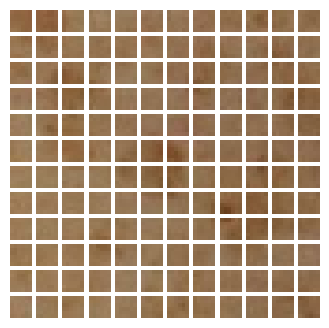

LEFT-UP


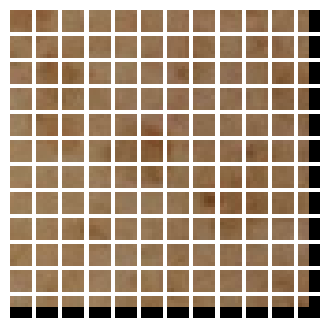

LEFT-DOWN


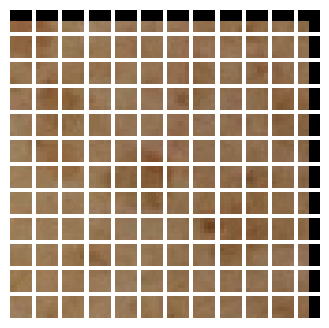

RIGHT-UP


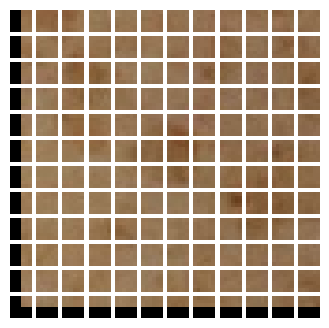

RIGHT-DOWN


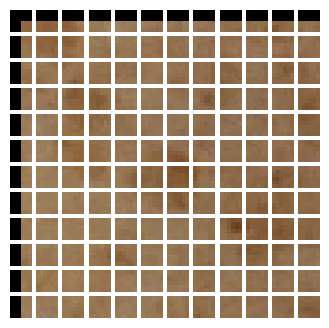

In [45]:
for batch in train_dataset.take(1):
    dict1,labels = batch
    images = dict1['images']
    tabular = dict1['tabular']
    sample_img = images[2,:,:,:]
    print(sample_img.shape)
    # Shifted Patch Tokenization: This layer takes the image, shifts it
    # diagonally and then extracts patches from the concatinated images
    (token, patch) = ShiftedPatchTokenization(vanilla=False)(sample_img)
    # (token, patch) = (token[0], patch[0])
    n = patch.shape[0]
    print(n)
    shifted_images = ["ORIGINAL", "LEFT-UP", "LEFT-DOWN", "RIGHT-UP", "RIGHT-DOWN"]
    for index, name in enumerate(shifted_images):
        print(name)
        count = 1
        plt.figure(figsize=(4, 4))
        for row in range(n):
            for col in range(n):
                plt.subplot(n, n, count)
                count = count + 1
                image = ops.reshape(patch[row][col], (PATCH_SIZE, PATCH_SIZE, 5 * 3))
                plt.imshow(image[..., 3 * index : 3 * index + 3])
                plt.axis("off")
        plt.show()
        


**Implement the patch encoding layer**

This layer accepts projected patches and then adds positional information to them.

In [46]:
@register_keras_serializable()
class PatchEncoder(layers.Layer):
    def __init__(
        self, num_patches=NUM_PATCHES, projection_dim=PROJECTION_DIM, **kwargs
    ):
        super().__init__(**kwargs)
        self.num_patches = num_patches
        self.position_embedding = layers.Embedding(
            input_dim=num_patches, output_dim=projection_dim
        )
        self.positions = ops.arange(start=0, stop=self.num_patches, step=1)

    def call(self, encoded_patches):
        encoded_positions = self.position_embedding(self.positions)
        encoded_patches = encoded_patches + encoded_positions
        return encoded_patches

**Implement Locality Self Attention**

In [47]:
@register_keras_serializable()
class MultiHeadAttentionLSA(layers.MultiHeadAttention):
    def __init__(self, **kwargs):
        super().__init__(**kwargs)
        # The trainable temperature term. The initial value is
        # the square root of the key dimension.
        self.tau = keras.Variable(math.sqrt(float(self._key_dim)), trainable=True)

    def _compute_attention(self, query, key, value, attention_mask=None, training=None):
        query = ops.multiply(query, 1.0 / self.tau)
        attention_scores = ops.einsum(self._dot_product_equation, key, query)
        attention_scores = self._masked_softmax(attention_scores, attention_mask)
        attention_scores_dropout = self._dropout_layer(
            attention_scores, training=training
        )
        attention_output = ops.einsum(
            self._combine_equation, attention_scores_dropout, value
        )
        return attention_output, attention_scores

In [48]:
# Implement the MLP
@register_keras_serializable()
def mlp(x, hidden_units, dropout_rate):
    for units in hidden_units:
        x = layers.Dense(units, activation="leaky_relu")(x)
        x = layers.Dropout(dropout_rate)(x)
    return x


# Build the diagonal attention mask
diag_attn_mask = 1 - ops.eye(NUM_PATCHES)
diag_attn_mask = ops.cast([diag_attn_mask], dtype="int8")

**Build the ViT**

In [49]:
vanilla=False
# inputs = layers.Input(shape=INPUT_SHAPE)
# Augment data.
# augmented = data_augmentation(img_input)
# Create patches.
(tokens, _) = ShiftedPatchTokenization(vanilla=vanilla)(img_input)
# Encode patches.
encoded_patches = PatchEncoder()(tokens)

# Create multiple layers of the Transformer block.
for _ in range(TRANSFORMER_LAYERS):
    # Layer normalization 1.
    x1 = layers.LayerNormalization(epsilon=1e-6)(encoded_patches)
    # Create a multi-head attention layer.
    if not vanilla:
        attention_output = MultiHeadAttentionLSA(
            num_heads=NUM_HEADS, key_dim=PROJECTION_DIM, dropout=0.1
        )(x1, x1, attention_mask=diag_attn_mask)
    else:
        attention_output = layers.MultiHeadAttention(
            num_heads=NUM_HEADS, key_dim=PROJECTION_DIM, dropout=0.1
        )(x1, x1)
    # Skip connection 1.
    x2 = layers.Add()([attention_output, encoded_patches])
    # Layer normalization 2.
    x3 = layers.LayerNormalization(epsilon=1e-6)(x2)
    # MLP.
    x3 = mlp(x3, hidden_units=TRANSFORMER_UNITS, dropout_rate=0.1)
    # Skip connection 2.
    encoded_patches = layers.Add()([x3, x2])

# Create a [batch_size, projection_dim] tensor.
representation = layers.LayerNormalization(epsilon=1e-6)(encoded_patches)
representation = layers.Flatten()(representation)
representation = layers.Dropout(0.3)(representation)

In [50]:
# Add MLP.
# features = mlp(representation, hidden_units=MLP_HEAD_UNITS, dropout_rate=0.2)
ACTIVATION_FUNCTION = 'leaky_relu'
KERNEL_INITIALIZER = keras.initializers.HeNormal()
x = Dense(2048,activation = ACTIVATION_FUNCTION,kernel_initializer = KERNEL_INITIALIZER)(representation)
y = Dense(256,activation = ACTIVATION_FUNCTION,kernel_initializer = KERNEL_INITIALIZER)(tab_feat)
y = Dropout(0.2)(y)
y = Dense(512,activation = ACTIVATION_FUNCTION,kernel_initializer = KERNEL_INITIALIZER)(y)
y = Dropout(0.2)(y)

combined = Concatenate()([x, y])
z = Dense(1024, activation=ACTIVATION_FUNCTION,kernel_initializer = KERNEL_INITIALIZER)(combined)
z = Dropout(0.2)(z)
z = Dense(512, activation=ACTIVATION_FUNCTION,kernel_initializer = KERNEL_INITIALIZER)(z)
# z = BatchNormalization()(z)
z = Dropout(0.2)(z)
z = Dense(256, activation=ACTIVATION_FUNCTION,kernel_initializer = KERNEL_INITIALIZER)(z)
# z = BatchNormalization()(z)
# Classify outputs.
logits = layers.Dense(1,activation='sigmoid')(z)

In [51]:
model = keras.Model(inputs=[img_input, tab_feat], outputs=logits,name='ViTsmall')

In [52]:
keras.utils.plot_model(model, "ViTsmall.png", show_shapes=True)

In [53]:
model.summary()

Model: "ViTsmall"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ images (InputLayer)       │ (None, 72, 72, 3)      │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ shifted_patch_tokenizati… │ [(None, 144, 64),      │         35,704 │ images[0][0]           │
│ (ShiftedPatchTokenizatio… │ (None, 12, 12, 540)]   │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ patch_encoder             │ (None, 144, 64)        │          9,216 │ shifted_patch_tokeniz… │
│ (PatchEncoder)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ layer_normalization_2     │ (None, 144, 64)        │            128 │ patch_encoder[0][0]    │
│ (LayerNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ multi_head_attention_lsa  │ (None, 144, 64)        │         66,369 │ layer_normalization_2… │
│ (MultiHeadAttentionLSA)   │                        │                │ layer_normalization_2… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ add (Add)                 │ (None, 144, 64)        │              0 │ multi_head_attention_… │
│                           │                        │                │ patch_encoder[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ layer_normalization_3     │ (None, 144, 64)        │            128 │ add[0][0]              │
│ (LayerNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_2 (Dense)           │ (None, 144, 128)       │          8,320 │ layer_normalization_3… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_1 (Dropout)       │ (None, 144, 128)       │              0 │ dense_2[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_3 (Dense)           │ (None, 144, 64)        │          8,256 │ dropout_1[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_2 (Dropout)       │ (None, 144, 64)        │              0 │ dense_3[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ add_1 (Add)               │ (None, 144, 64)        │              0 │ dropout_2[0][0],       │
│                           │                        │                │ add[0][0]              │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ layer_normalization_4     │ (None, 144, 64)        │            128 │ add_1[0][0]            │
│ (LayerNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ multi_head_attention_lsa… │ (None, 144, 64)        │         66,369 │ layer_normalization_4… │
│ (MultiHeadAttentionLSA)   │                        │                │ layer_normalization_4… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ add_2 (Add)               │ (None, 144, 64)        │              0 │ multi_head_attention_… │
│                      

 Total params: 23,016,193 (87.80 MB)

 Trainable params: 23,016,193 (87.80 MB)

 Non-trainable params: 0 (0.00 B)

In [54]:
# lr_schedule = keras.optimizers.schedules.ExponentialDecay(
#     initial_learning_rate=1e-2,
#     decay_steps=5000,
#     decay_rate=0.9)
boundaries = [300,1000]
values = [1e-3,1e-4,1e-5]
lr_schedule = keras.optimizers.schedules.PiecewiseConstantDecay(
    boundaries, values, name="PiecewiseConstant"
)
model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=lr_schedule,weight_decay=1e-6),
    loss = keras.losses.BinaryFocalCrossentropy(apply_class_balancing=True,alpha=0.25,gamma=3.0,label_smoothing = 0.1),
    # loss = keras.losses.BinaryCrossentropy(),
    metrics=[keras.metrics.AUC(curve='PR', name='PR_pAUC'),keras.metrics.AUC(curve='ROC', name='ROC_pAUC')]
)

In [55]:
# Define callbacks
early_stopping = EarlyStopping(
    monitor='val_loss',
    mode='min',
    patience=10, 
    restore_best_weights=True,
    start_from_epoch = 5
)

# reduce_lr = ReduceLROnPlateau(
#     monitor='loss', 
#     factor=0.2, 
#     patience=3, 
#     min_lr=1e-6,
#     start_from_epoch = 2 
# )

checkpoint = ModelCheckpoint(
    filepath='best_model.keras', 
    monitor='val_loss', 
    save_best_only=True
)


In [56]:
class_weights = compute_class_weight('balanced', classes=np.unique(y_train_final), y=y_train_final)
class_weights = dict(enumerate(class_weights))
# class_weights = {0:0.8,1:10.0}
print("Class Weights:", class_weights)

Class Weights: {0: 0.55, 1: 5.5}


In [57]:
history = model.fit(
        train_dataset,
        validation_data=val_dataset,
        epochs=102,
        callbacks=[early_stopping, checkpoint],
        verbose=1,
        # class_weight=class_weights
    )

Epoch 1/102
152/152 ━━━━━━━━━━━━━━━━━━━━ 131s 442ms/step - PR_pAUC: 0.1174 - ROC_pAUC: 0.5529 - loss: 2.3334 - val_PR_pAUC: 0.5532 - val_ROC_pAUC: 0.8723 - val_loss: 0.0161
Epoch 2/102
152/152 ━━━━━━━━━━━━━━━━━━━━ 23s 151ms/step - PR_pAUC: 0.4526 - ROC_pAUC: 0.8363 - loss: 0.0147 - val_PR_pAUC: 0.6067 - val_ROC_pAUC: 0.9080 - val_loss: 0.0113
Epoch 3/102
152/152 ━━━━━━━━━━━━━━━━━━━━ 23s 150ms/step - PR_pAUC: 0.5436 - ROC_pAUC: 0.8851 - loss: 0.0121 - val_PR_pAUC: 0.6335 - val_ROC_pAUC: 0.9177 - val_loss: 0.0111
Epoch 4/102
152/152 ━━━━━━━━━━━━━━━━━━━━ 23s 150ms/step - PR_pAUC: 0.5755 - ROC_pAUC: 0.8912 - loss: 0.0115 - val_PR_pAUC: 0.6463 - val_ROC_pAUC: 0.9253 - val_loss: 0.0107
Epoch 5/102
152/152 ━━━━━━━━━━━━━━━━━━━━ 23s 150ms/step - PR_pAUC: 0.5913 - ROC_pAUC: 0.8944 - loss: 0.0114 - val_PR_pAUC: 0.6613 - val_ROC_pAUC: 0.9302 - val_loss: 0.0103
Epoch 6/102
152/152 ━━━━━━━━━━━━━━━━━━━━ 23s 152ms/step - PR_pAUC: 0.5996 - ROC_pAUC: 0.9031 - loss: 0.0110 - val_PR_pAUC: 0.6714 - val_ROC

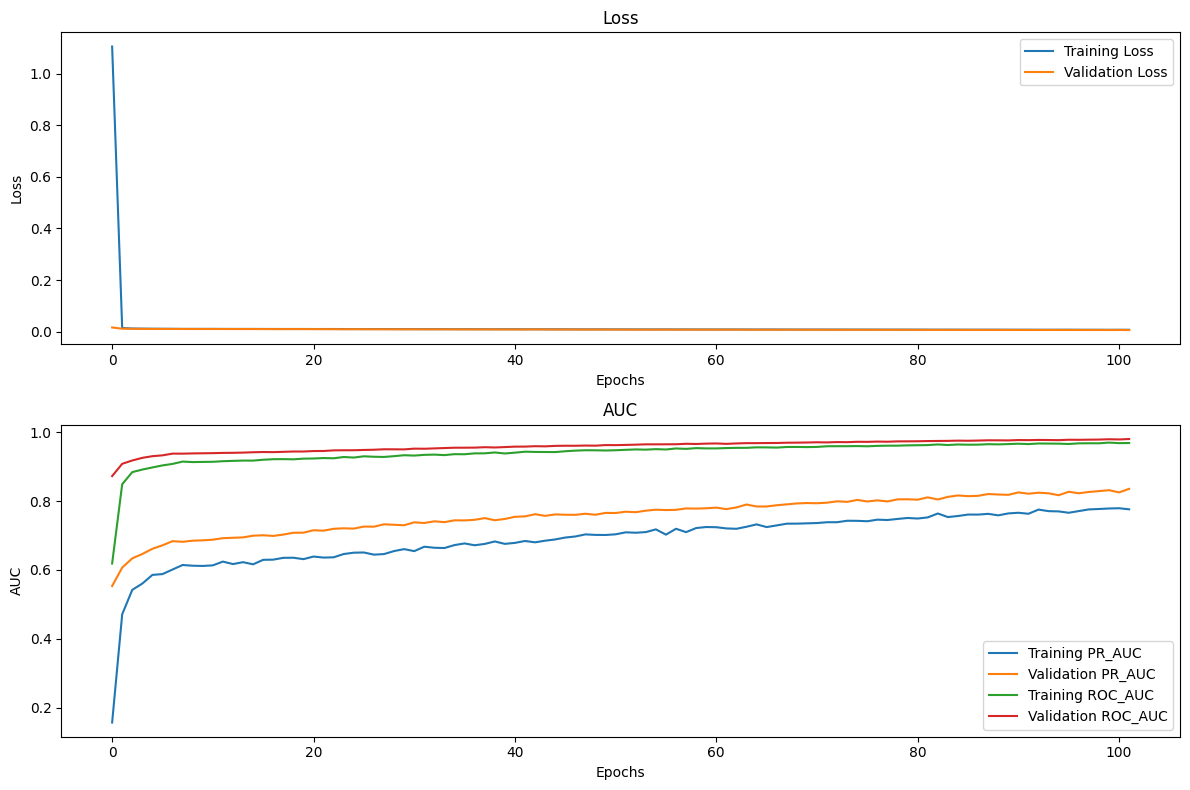

In [58]:
plt.figure(figsize=(12, 8))

# Plot training and validation loss
plt.subplot(2, 1, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Plot training and validation AUC
plt.subplot(2, 1, 2)
plt.plot(history.history['PR_pAUC'], label='Training PR_AUC')
plt.plot(history.history['val_PR_pAUC'], label='Validation PR_AUC')
plt.plot(history.history['ROC_pAUC'], label='Training ROC_AUC')
plt.plot(history.history['val_ROC_pAUC'], label='Validation ROC_AUC')
plt.title('AUC')
plt.xlabel('Epochs')
plt.ylabel('AUC')
plt.legend()

plt.tight_layout()
plt.show()


## Prediction for test data

In [59]:
# # now load the best model
custom_objects = {
    "ShiftedPatchTokenization": ShiftedPatchTokenization,
    "PatchEncoder": PatchEncoder,
    "MultiHeadAttentionLSA": MultiHeadAttentionLSA
}
best_model = keras.models.load_model('best_model.keras', custom_objects=custom_objects)

In [60]:
predictions = best_model.predict(test_dataset, verbose=1)
predictions_series = pd.Series(predictions.flatten(), name='Predictions')
# predictions_series = predictions_series.clip(lower=1e-6, upper=0.999999)

1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step


In [61]:
sub_df = pd.concat([X_test['isic_id'],predictions_series],axis=1)
sub_df.columns = ['isic_id','target']
sub_df.head()

,isic_id,target
0,ISIC_0015657,0.073463
1,ISIC_0015729,0.021580
2,ISIC_0015740,0.115309


In [62]:
 sub_df.to_csv('submission.csv', index=False)